In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sct
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import binom

### CSVファイルの読み込み

In [4]:
#CSVデータの読み込み
data = pd.read_csv("chap7_data.csv")
data.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


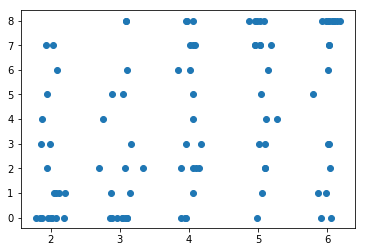

In [9]:
#そのまま散布図にすると点が重なってしまい数の多さがわからないため、
#正規分布のズレを加えている。

#2項分布では説明がつかないように見える
data["x_bure"] = np.random.normal(loc=0,scale=0.1,size=100)
plt.scatter(data.x + data.x_bure, data.y)

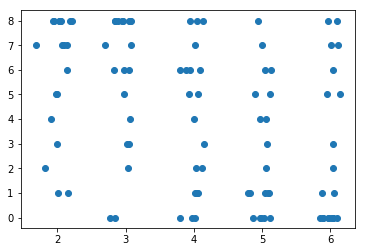

In [12]:
data["x_bure"] = np.random.normal(loc=0,scale=0.1,size=100)

#2項分布では説明がつかないように見える
plt.scatter(data.x + data.x_bure, data.N - data.y)

In [13]:
model = smf.glm('y + I(N-y)~ x', data=data, family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Fri, 28 Feb 2020   Deviance:                       513.84
Time:                        15:51:05   Pearson chi2:                     428.
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000      -2.614      -1.684
x              0.5104      0.056      9.179      0.000       0.401       0.619
==============================================================================
"""

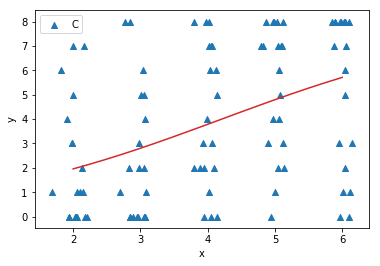

In [18]:
z = lambda beta1, beta2, x: beta1 + beta2 * x
x = np.arange(data['x'].min(), data['x'].max() + 0.01, 0.01)

logistic = lambda z: 1 / (1 + np.exp(-z))

#明らかにフィッティングしていない
plt.plot(x, [logistic(z_i) * 8 for z_i in z(result.params['Intercept'], result.params['x'], x)], color="tab:red")
plt.scatter(data.x + data.x_bure, data.y, marker ='^', label = 'C', color="tab:blue")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

(array([3., 1., 4., 2., 1., 1., 2., 3., 3., 0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

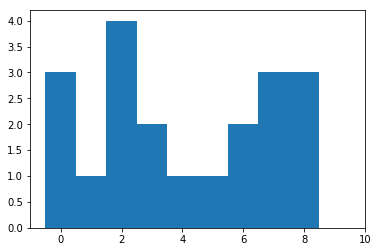

In [25]:
#例えばx=4でのヒストグラムを確認する
data_4 = data[data.x==4]
plt.hist(data_4.y, bins=np.arange(-0.5, 10.5, 1.0))

In [26]:
#2項分布との比較
#2項分布の平均と分散の関係
#平均:np
#分散:np*(1-p)
#本データではn=8(このnは試行数の20ではないことに注意)
data_4.describe()

,N,y,x,id,x_bure
count,20.0,20.000000,20.0,20.00000,20.000000
mean,8.0,4.050000,4.0,50.50000,0.003840
std,0.0,2.892367,0.0,5.91608,0.098834
min,8.0,0.000000,4.0,41.00000,-0.201460
25%,8.0,2.000000,4.0,45.75000,-0.054478
50%,8.0,3.500000,4.0,50.50000,0.020186
75%,8.0,7.000000,4.0,55.25000,0.062998
max,8.0,8.000000,4.0,60.00000,0.143990


### 過分散

In [50]:
#平均4.05なのでp=0.5程度
#分散の理論値はnp(1-p) => 8 * 0.5 * 0.5 = 2
#分散の実測値は8.36なので一致しない
#データの分散が大きく理論値からずれているため、このデータは2項モデルでは説明できない
data_4.describe().y['std'] ** 2

8.365789473684213

In [51]:
import pyper

ModuleNotFoundError: No module named 'pyper'

### GLMM
* データの質という観点からはデータの取得元はすべて異なっているのが望ましい
* 同じ100個のデータがあった場合、異なる100人から1回取得する場合と、異なる10人からそれぞれ10回取得するのでは意味が異なる
* 前者を反復（すべて異なる個体からデータを取得する/データの取得元の個体差が存在しない）と呼ぶ
* 後者を疑似反復（同じ個体からデータを取得する/データの取得元に個体差が存在する）と呼ぶ
* 疑似反復ではデータの取得元を考慮しないとデータに偏りが存在する
* 反復の場合は個体の区別は不要なためGLMを用いる
* 疑似反復の場合は各個体固有の特性を区別するためにGLMMを用いる
* 複数のパラメータに疑似反復がある場合は計算量が多いためMCMCを用いる